# Create 2D representation of trees based on a given distance

## 1 Setup

### 1.1 Database parameters

In [1]:
DB_NAME = 'spreadr_exp_1'
DB_USER = 'spreadr_analysis'

### 1.2 Boilerplate database setup

In [2]:
import os, sys
sys.path.insert(1, os.path.join(os.path.abspath(os.curdir), 'spreadr'))

import django
from django.conf import settings
from spreadr import settings as base_spreadr_settings
spreadr_settings = base_spreadr_settings.__dict__.copy()
spreadr_settings['DATABASES'] = {
    'default': {
        'ENGINE': 'django.db.backends.mysql',
        'NAME': DB_NAME,
        'USER': DB_USER
    }
}
settings.configure(**spreadr_settings)
django.setup()

### 1.3 Imports for the rest of the analysis

In [3]:
import collections
import functools
from itertools import zip_longest

from django.db.models import Count
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from nltk.corpus import stopwords as nltk_stopwords
from nltk.metrics import jaccard_distance, edit_distance
from nltk.stem.snowball import EnglishStemmer as SnowballStemmer
from nltk.tokenize import word_tokenize as nltk_word_tokenize
import numpy as np
import seaborn as sb
from sklearn.manifold import MDS

from gists.models import Sentence, Tree

### 1.4 Utilities

In [4]:
def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

In [5]:
class memoized(object):
    '''Decorator. Caches a function's return value each time it is called.
    If called later with the same arguments, the cached value is returned
    (not reevaluated).
    '''
    def __init__(self, func):
        self.func = func
        self.cache = {}
    def __call__(self, *args):
        if not isinstance(args, collections.Hashable):
            # uncacheable. a list, for instance.
            # better to not cache than blow up.
            return self.func(*args)
        if args in self.cache:
            return self.cache[args]
        else:
            value = self.func(*args)
            self.cache[args] = value
            return value
    def __repr__(self):
        '''Return the function's docstring.'''
        return self.func.__doc__
    def __get__(self, obj, objtype):
        '''Support instance methods.'''
        return functools.partial(self.__call__, obj)

## 2 Data processing tools

### 2.1 Select training/experiment/game sentences and trees

In [6]:
# For sentences
Sentence.objects.__class__.training = property(lambda self: self.get_queryset().filter(bucket__exact='training'))
Sentence.objects.__class__.experiment = property(lambda self: self.get_queryset().filter(bucket__exact='experiment'))
Sentence.objects.__class__.game = property(lambda self: self.get_queryset().filter(bucket__exact='game'))

# Test
assert Sentence.objects.training.count() == 6
assert Sentence.objects.experiment.count() == Sentence.objects.count() - 6 - Sentence.objects.game.count()

# For trees
Tree.objects.__class__.training = property(lambda self: self.get_queryset().filter(root__bucket__exact='training'))
Tree.objects.__class__.experiment = property(lambda self: self.get_queryset().filter(root__bucket__exact='experiment'))
Tree.objects.__class__.game = property(lambda self: self.get_queryset().filter(root__bucket__exact='game'))

# Test
assert Tree.objects.training.count() == 6
assert Tree.objects.experiment.count() == Tree.objects.count() - 6 - Tree.objects.game.count()

### 2.2 Find the head of the branch a sentence is in

In [7]:
def get_head(self):
    if self.parent is None:
        raise ValueError('Already at root')
    if self.parent.parent is None:
        return self
    return self.parent.head

Sentence.head = property(get_head)

# Test
tree = Tree.objects.annotate(sentences_count=Count('sentences')).filter(sentences_count__gte=10).first()
heads = set(tree.root.children.all())
def _add_with_children(sentence, children):
    children.append(sentence)
    for child in sentence.children.all():
        _add_with_children(child, children)
def walk_children(sentence):
    res = []
    _add_with_children(sentence, res)
    return res
branches = {}
for head in heads:
    branches[head] = walk_children(head)

for sentence in tree.sentences.all():
    if sentence == tree.root:
        try:
            sentence.head
        except ValueError:
            pass  # Test passed
        else:
            raise Exception('Exception not raised on root')
    else:
        assert sentence in branches[sentence.head]

### 2.3 Preprocess sentences

For each sentence text, we want the content words. So:
* tokenize
* set to lowercase
* remove punctuation
* remove words $\leq$ 2 characters
* remove stopwords
* stem

and set the result as `content_words` on each `Sentence`.

In [8]:
def _filter(words, exclude_list):
    return filter(lambda w: w not in exclude_list, words)

def filter_punctuation(words):
    return _filter(words, [',', '.', ';', '!', '?'])

stopwords = set(nltk_stopwords.words('english'))
stopwords.add("n't")  # Missing from the corpus, and appears with tokenization

def filter_stopwords(words):
    return _filter(words, stopwords)

def filter_lowercase(words):
    return map(lambda w: w.lower(), words)

def filter_length(words):
    return filter(lambda w: len(w) > 2, words)

stemmer = SnowballStemmer(ignore_stopwords=True)

def filter_stem(words):
    return map(lambda w: stemmer.stem(w), words)

filters = [nltk_word_tokenize,
           filter_lowercase,
           filter_punctuation,
           filter_length,
           filter_stopwords,
           filter_stem]

@memoized
def get_content_words(self):
    processed = self.text
    for f in filters:
        processed = f(processed)
    return list(processed)

Sentence.content_words = property(get_content_words)

# Test
assert Sentence.objects.get(id=1).content_words == ['young', 'boy', 'sudden', 'hit', 'littl', 'girl']
assert Sentence.objects.get(id=2).content_words == ['forget', 'leav', 'door', 'open', 'leav', 'offic']

### 2.4 Measure distances between sentences

In [9]:
@memoized
def ordered_distance(self, sentence):
    self_content_words = self.content_words
    sentence_content_words = sentence.content_words
    return edit_distance(self_content_words, sentence_content_words) / \
        max(len(self_content_words), len(sentence_content_words))

@memoized
def unordered_distance(self, sentence):
    return jaccard_distance(set(self.content_words), set(sentence.content_words))

Sentence.ordered_distance = ordered_distance
Sentence.unordered_distance = unordered_distance

# Testing this is hard (we don't have predictable data for it), so we test values for 0 and 1 only
assert Sentence.objects.get(id=1).ordered_distance(Sentence.objects.get(id=1)) == 0.0
assert Sentence.objects.get(id=1).unordered_distance(Sentence.objects.get(id=1)) == 0.0
assert Sentence.objects.get(id=1).ordered_distance(Sentence.objects.get(id=2)) == 1.0
assert Sentence.objects.get(id=1).unordered_distance(Sentence.objects.get(id=2)) == 1.0

### 2.5 Multidimensional-scale a tree

In [10]:
@memoized
def similarities(self, distance_type):
    if distance_type not in ['ordered', 'unordered']:
        raise ValueError("Unkown distance type (not one of ['ordered', 'unordered']): {}".format(distance_type))
    distance_name = distance_type + '_distance'

    # Compute similarities matrix
    size = self.sentences.count()
    similarities = np.zeros((size, size))
    sentences = self.sentences.all()
    indices = {}
    for i, s1 in enumerate(sentences):
        if s1.id not in indices:
            indices[s1.id] = i
        for j, s2 in enumerate(sentences):
            similarities[i, j] = getattr(s1, distance_name)(s2)
    
    # Check we saw all the indices go past
    assert len(indices) == size
    
    return (similarities, indices)

@memoized
def scaling(self, distance_type, is_metric, init=None):
    # Compute similarities
    similarities, indices = self.similarities(distance_type)
    
    # Compute scaling
    if init is None:
        mds = MDS(n_components=2, metric=is_metric, max_iter=3000, dissimilarity='precomputed', n_jobs=-2)
        pos = mds.fit_transform(similarities)
    else:
        mds = MDS(n_components=2, metric=is_metric, max_iter=3000, dissimilarity='precomputed', n_jobs=-2, n_init=1)
        pos = mds.fit_transform(similarities, init=init)
    
    return (pos, mds.stress_, indices)

@memoized
def scaled_plot(self, ax, distance_type, is_metric, init=None):
    pos, stress, indices = self.scaling(distance_type, is_metric, init)
    
    # Prepare variable
    sentences = self.sentences.all()
    size = len(sentences)
    leaves = set([s for s in sentences if s.children.count() == 0])

    # Plot sentences
    leaves_indices = [indices[leaf.id] for leaf in leaves]
    colors = np.array(['#64B5CD'] * size)
    colors[indices[self.root.id]] = '#C44E52'
    colors[leaves_indices] = '#55A868'
    sizes = np.ones(size) * 100
    sizes[indices[self.root.id]] = 200
    sizes[leaves_indices] = 200
    ax.scatter(pos[:, 0], pos[:, 1], c=colors, s=sizes, edgecolors=(0, 0, 0, 0))
    
    # Plot links
    heads_indices = {}
    for i, head in enumerate(self.root.children.all()):
        heads_indices[head.id] = i
    palette = sb.cubehelix_palette(len(heads), rot=2, as_cmap=True)
    links = [[s, child] for s in sentences for child in s.children.all()]
    segments = [[pos[indices[s.id], :], pos[indices[child.id], :]] for (s, child) in links]
    colors = np.array([heads_indices[child.head.id] for (_, child) in links])
    lc = LineCollection(segments,
                        zorder=1, cmap=palette,
                        norm=plt.Normalize(0, colors.max()))
    lc.set_array(colors)
    lc.set_linewidths(1.5 * np.ones(len(segments)))
    ax.add_collection(lc)
    
    return (pos, stress)

Tree.similarities = similarities
Tree.scaling = scaling
Tree.scaled_plot = scaled_plot

## 3 Get some actual results

### 3.1 Spammed and unspammed stresses

Hopefully unspamming the trees will reduce final stress of our downscalings.

#### 3.1.1 Stress with spammed trees

In [11]:
trees = Tree.objects.experiment.all()
stresses = np.zeros_like(trees)
print
print('Computing...', end='')
for i, tree in enumerate(trees):
    print(' #{}'.format(tree.id), end='')
    stresses[i] = tree.scaling('ordered', True)[1]

Computing... #1 #2 #3 #4 #5 #6 #7 #8 #9 #10 #11 #12 #13 #14 #15 #16 #17 #18 #20 #22 #23 #25 #26 #27 #28 #29 #30 #31 #32 #33 #34 #36 #37 #38 #39 #40 #41 #42 #43 #44 #45 #46 #47 #48 #49 #50 #51 #52 #53 #54

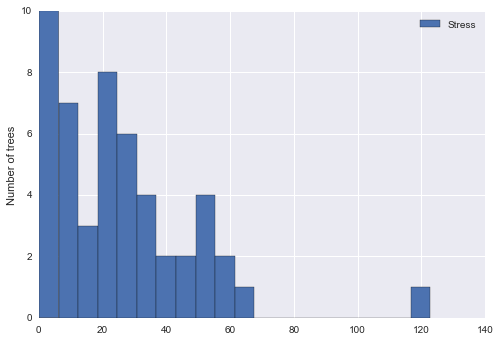

In [12]:
fig, ax = plt.subplots()
ax.hist(stresses, 20, label='Stress')
ax.set_ylabel('Number of trees')
ax.legend(loc='best')

### 3.1.2 Stress with unspammed trees

In [13]:
# TBD

### 3.2 Plot evolutions

Computing... #1

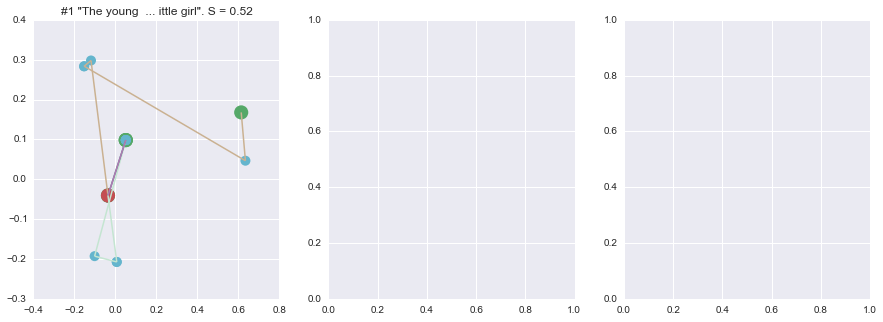

In [14]:
# Parameters
trees = Tree.objects.experiment[:1]
n_cols = 3

# Plot
n_rows = int(np.ceil(trees.count() / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
print('Computing...', end='')
for i, trees_line in enumerate(grouper(trees, n_cols)):
    for j, tree in enumerate(trees_line):
        if tree is None:
            break
        
        print(' #{}'.format(tree.id), end='')

        text = tree.root.text
        if len(text) > 25:
            text = text[:10] + ' ... ' + text[-10:]
        stress = tree.scaled_plot(axes.flat[i * n_cols + j], 'ordered', True)[1]
        axes.flat[i * n_cols + j].set_title('#{} "{}". S = {:.2}'.format(tree.id, text, stress))